# پیتر و گرگ: محیط واقعی

در شرایط ما، پیتر توانست تقریباً بدون خستگی یا گرسنگی حرکت کند. در دنیای واقعی‌تر، او باید هر از گاهی بنشیند و استراحت کند و همچنین خودش را تغذیه کند. بیایید دنیایمان را واقعی‌تر کنیم، با اجرای قوانین زیر:

1. با حرکت از یک مکان به مکان دیگر، پیتر **انرژی** از دست می‌دهد و مقداری **خستگی** کسب می‌کند.
2. پیتر می‌تواند با خوردن سیب انرژی بیشتری به دست آورد.
3. پیتر می‌تواند با استراحت زیر درخت یا روی چمن (یعنی رفتن به مکانی در صفحه که درخت یا چمن - میدان سبز - دارد) از شر خستگی خلاص شود.
4. پیتر باید گرگ را پیدا کند و بکشد.
5. برای کشتن گرگ، پیتر باید سطح مشخصی از انرژی و خستگی داشته باشد، در غیر این صورت در نبرد شکست می‌خورد.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

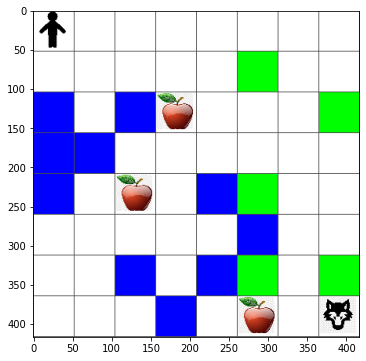

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## تعریف وضعیت

در قوانین جدید بازی، باید انرژی و خستگی را در هر وضعیت صفحه پیگیری کنیم. بنابراین، یک شیء `state` ایجاد خواهیم کرد که تمام اطلاعات مورد نیاز درباره وضعیت فعلی مسئله را شامل می‌شود، از جمله وضعیت صفحه، سطح فعلی انرژی و خستگی، و اینکه آیا می‌توانیم در وضعیت پایانی گرگ را شکست دهیم یا خیر:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

بیایید سعی کنیم مسئله را با استفاده از قدم زدن تصادفی حل کنیم و ببینیم آیا موفق می‌شویم:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## تابع پاداش

### مقدمه
تابع پاداش یکی از اجزای کلیدی در سیستم‌های یادگیری تقویتی است. این تابع به عامل کمک می‌کند تا رفتار مطلوب را از طریق ارائه بازخورد مثبت یا منفی یاد بگیرد.

### تعریف تابع پاداش
تابع پاداش به صورت زیر تعریف می‌شود:

- **ورودی‌ها**: وضعیت فعلی، اقدام انجام‌شده، و وضعیت بعدی.
- **خروجی**: مقدار عددی که نشان‌دهنده کیفیت اقدام انجام‌شده در وضعیت فعلی است.

### نکات مهم
[!NOTE] تابع پاداش باید به گونه‌ای طراحی شود که عامل را به سمت اهداف مطلوب هدایت کند.

[!WARNING] طراحی نادرست تابع پاداش ممکن است منجر به رفتارهای غیرمنتظره یا نامطلوب شود.

### مثال
در اینجا یک مثال ساده از تابع پاداش آورده شده است:

@@CODE_BLOCK_1@@

### بهترین شیوه‌ها
برای طراحی یک تابع پاداش موثر، موارد زیر را در نظر بگیرید:

- **شفافیت**: عامل باید بتواند به وضوح ارتباط بین اقدامات و پاداش‌ها را درک کند.
- **تعادل**: پاداش‌ها باید به گونه‌ای تنظیم شوند که از رفتارهای افراطی جلوگیری شود.
- **سازگاری**: تابع پاداش باید با اهداف کلی سیستم هماهنگ باشد.

[!TIP] از آزمایش‌های متعدد برای تنظیم و بهینه‌سازی تابع پاداش استفاده کنید.

### نتیجه‌گیری
تابع پاداش نقش حیاتی در موفقیت سیستم‌های یادگیری تقویتی دارد. طراحی دقیق و آزمایش مداوم می‌تواند به دستیابی به نتایج مطلوب کمک کند.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## الگوریتم Q-Learning

الگوریتم یادگیری اصلی تقریباً بدون تغییر باقی می‌ماند، فقط به جای موقعیت تخته، از `state` استفاده می‌کنیم.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

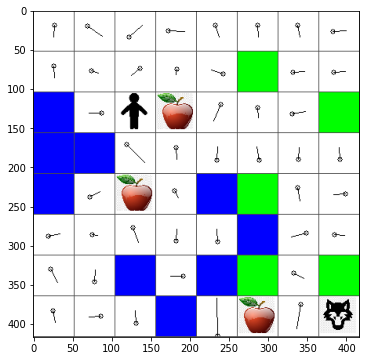

In [11]:
m.plot(Q)

## نتایج

بیایید ببینیم آیا توانستیم پیتر را برای مبارزه با گرگ آموزش دهیم!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


اکنون موارد غرق شدن بسیار کمتر دیده می‌شود، اما پیتر هنوز همیشه نمی‌تواند گرگ را بکشد. سعی کنید آزمایش کنید و ببینید آیا می‌توانید با بازی کردن با هایپرپارامترها این نتیجه را بهبود دهید.


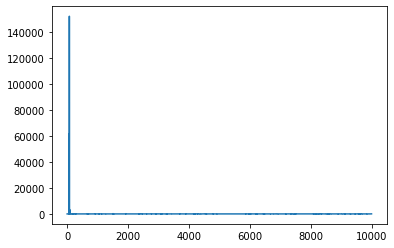

In [13]:
plt.plot(lpath)


---

**سلب مسئولیت**:  
این سند با استفاده از سرویس ترجمه هوش مصنوعی [Co-op Translator](https://github.com/Azure/co-op-translator) ترجمه شده است. در حالی که ما تلاش می‌کنیم دقت را حفظ کنیم، لطفاً توجه داشته باشید که ترجمه‌های خودکار ممکن است شامل خطاها یا نادرستی‌ها باشند. سند اصلی به زبان اصلی آن باید به عنوان منبع معتبر در نظر گرفته شود. برای اطلاعات حساس، توصیه می‌شود از ترجمه حرفه‌ای انسانی استفاده کنید. ما مسئولیتی در قبال سوءتفاهم‌ها یا تفسیرهای نادرست ناشی از استفاده از این ترجمه نداریم.
